In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
import scipy as sc
from scipy.spatial import Delaunay
from scipy.spatial.distance import cdist
import random

import pickle

from simplicial_kuramoto import SimplicialComplex
from simplicial_kuramoto.graph_generator import modular_graph
from simplicial_kuramoto.integrators import *
from simplicial_kuramoto.plotting import *

In [20]:
def get_delauney_holes_multi(n_points, centre_holes,radius,points=None):


    if points is None:
        x = np.random.rand(n_points)
        y = np.random.rand(n_points)
        points = np.vstack([x,y]).T

    tri = Delaunay(points)

    edge_list = []
    
    
    idx_inside=np.empty([0], dtype=int)
    for i in range(centre_holes.shape[0]):
        idx_inside=np.hstack([idx_inside,encloses([centre_holes[i]],points,radius)[1]])
    
    for t in tri.simplices:
        
        if t[0] not in idx_inside and t[1] not in idx_inside:
            edge_list.append([t[0], t[1]])
     
        if t[1] not in idx_inside and t[2] not in idx_inside:
            edge_list.append([t[1], t[2]])

        if t[0] not in idx_inside and t[2] not in idx_inside:
            edge_list.append([t[0], t[2]])   


            
    graph = nx.Graph()
    #graph.add_nodes_from(np.arange(len(points)))    
    graph.add_edges_from(edge_list)
    
    Gcc = sorted(nx.connected_components(graph), key=len, reverse=True)
    g = graph.subgraph(Gcc[0])
    
    
    return g, points


def encloses(centre, points, radius):
    inside_hole = (cdist(centre, points, 'euclidean') <= radius)
    idx_inside = np.where(inside_hole )
    
    return idx_inside


# Plotting the nullspace of L1

def Null_Space_Plot(graph):
    complex_delaunay = SimplicialComplex(graph=graph, no_faces=False)


    KerL1=sc.linalg.null_space(complex_delaunay.L1.todense())

    for i in range(KerL1.shape[1]):
        plt.figure()
        nx.draw_networkx_nodes(graph, pos=points, node_size=5)
        nx.draw_networkx_edges(
                graph,
                pos=points,
                edge_color=KerL1[:,i],
                edge_cmap=plt.get_cmap("bwr"),
                width=5,
                edge_vmin=np.min(KerL1[:,i]),
                edge_vmax=np.max(KerL1[:,i]),
            )
        plt.title('Null space of L1, vector '+str(i))
        plt.show()

# Two holes

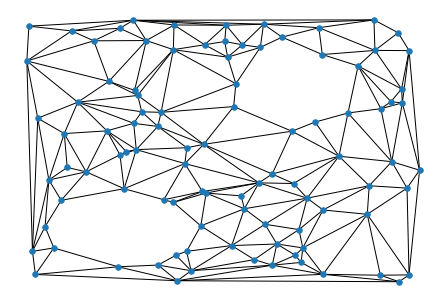

In [22]:
centre_hole_1 = np.array([[0.25,0.25]])
centre_hole_2 = np.array([[0.75,0.75]])

centre_holes=np.concatenate((centre_hole_1,centre_hole_2),axis=0)

radius = 0.1

graph, points = get_delauney_holes_multi(100,centre_holes,radius)
pos = dict(enumerate(points))
nx.draw(graph,pos,node_size=30)


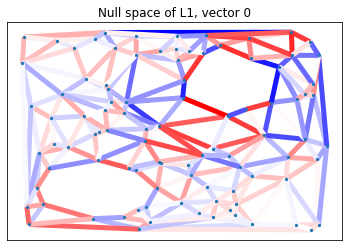

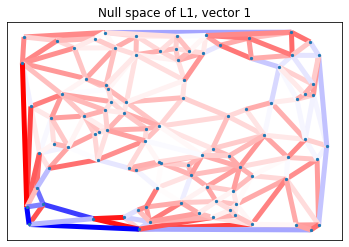

In [26]:
np.random.seed(0)

t_max = 100
n_t = 100
labels = dict(((u, v), d) for d, (u, v) in enumerate(graph.edges))


Null_Space_Plot(graph)


initial_phase = np.random.uniform(0, 2 * np.pi, len(graph.edges))
complex_delaunay = SimplicialComplex(graph=graph, no_faces=False)
KerL1=sc.linalg.null_space(complex_delaunay.L1.todense())


In [24]:
edge_result = integrate_edge_kuramoto(complex_delaunay, initial_phase, t_max, n_t, alpha_1=1, alpha_2=0)


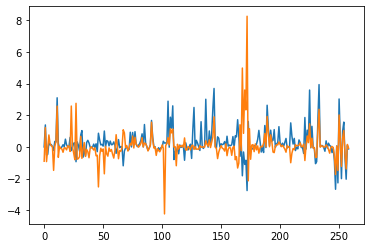

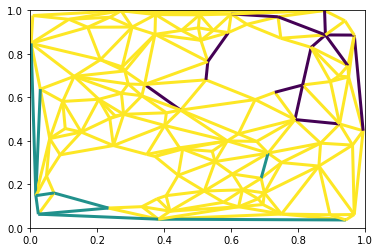

In [39]:
# take the the null space vectors and multiply by the phase from solver
# then take average across time

# solution 1
x1 = KerL1[:,0]
y1 = edge_result.y*x1[:,None]
plt.plot(y1.mean(axis=1))

# solution 2
x2 = KerL1[:,1]
y2 = edge_result.y*x2[:,None]
plt.plot(y2.mean(axis=1))

# set some limit
limit = 2

# define the edge communities around the holes based on the null space and the phase
X= np.vstack([y1.mean(axis=1),y2.mean(axis=1)]).T
edge_community_assignment = abs(X).argmax(axis=1)

# set edges not inside a community to 99999
edge_community_assignment[~(abs(X)>limit).max(axis=1)] = 2

plt.figure()
nx.draw_networkx_edges(
                graph,
                pos=points,
                edge_color=edge_community_assignment,
                width=3,
            )

Global metastability=0.009048145169094976
Chimeraness=0.018174819671346175
Coalition Entropy=0.5510526887166635


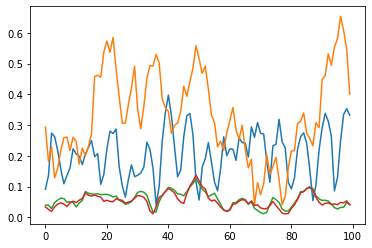

In [40]:

op=module_order_parameter(edge_result.y,edge_community_assignment)
gms, chi = Shanahan_indices(op)
ce = coalition_entropy(op, 0.2)
gop, phase_gradient = module_gradient_parameter(edge_result.y,edge_community_assignment) 
ceg = coalition_entropy(gop)
plt.figure()
plt.plot(op.T)
print('Global metastability={}'.format(gms))
print('Chimeraness={}'.format(chi))
print('Coalition Entropy={}'.format(ce))
